In [1]:
from phantominator import shepp_logan
from matplotlib import pyplot as plt
import numpy as np

import torch

from loguru import logger

from transformers import AutoModelForCausalLM

import torch_dct as dct

/home/nsagan/experiments/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from lplr.quantization import *
from lplr.weight_compressors import *
from lplr.hyperparameter_sweeps import *
from lplr.benchmarkers import *
from peft.utils.loftq_utils import loftq_init
from peft.utils.loftq_lplr_utils import loftq_lplr_init
from peft.utils.quantization_utils import NFQuantizerFactory
from lplr.admm_optimize import *
from lplr.enums import *

In [4]:
DEFAULT_DEVICE = "cuda:2"

In [5]:
mistral = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:22<00:00, 11.46s/it]


In [242]:
layer_name, X_mis = list(mistral.named_parameters())[20]
X_mis = X_mis.detach().to(DEFAULT_DEVICE)
n, d = X_mis.shape

torch.Size([1024, 4096])


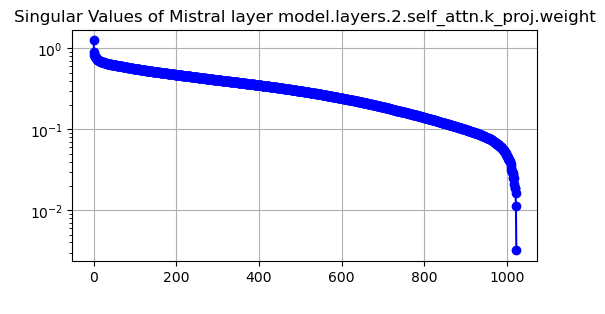

In [243]:
print(X_mis.shape)
_, S, _ = torch.linalg.svd(X_mis.float(), full_matrices=False)

# Plot the singular values
plt.figure(figsize=(6, 3))
plt.plot(S.cpu(), marker='o', linestyle='-', color='b')
plt.title(f'Singular Values of Mistral layer {layer_name}')
plt.xlabel('Index', color="white")
plt.ylabel('Singular Value', color="white")
plt.yscale('log')
plt.grid(True)
plt.show()

In [322]:
rank_8b=16
rank_4b = 350
rank_2b = 100
k = 0
sparsity=int(n*d/4)
BQ=0
BS=4

print("Bit budget: %e" % (BQ*n*d + (8*rank_8b + 4*rank_4b + 2*rank_2b)*(n+d) + (sparsity > 0)*n*d + sparsity*BS))
print(f"Percent nonzero: {100 * sparsity / (n*d)}")

Bit budget: 1.723597e+07
Percent nonzero: 25.0


In [323]:
print("Target bit budget: %e" % (4*n*d + 16*16*(n+d)))

Target bit budget: 1.808794e+07


In [324]:
# _, _, errors = weight_decomposition_no_admm(
#     X=X_mis,
#     rank=rank,
#     sparsity=sparsity,
#     BQ=BQ,
#     BLR=BLR,
#     BS=BS,
#     quantizer_factory=NFQuantizerFactory(method="normal", low_memory_quantizer=True),
#     iters=50,
#     log_errors=True
# )

In [325]:
X = X_mis
n, d = X.shape
H1_dim = int(2**np.ceil(np.log2(n)))
H2_dim = int(2**np.ceil(np.log2(d)))

H1 = torch.from_numpy(hadamard(H1_dim)).to(X.device).float()
H1 *= rademacher_rv(H1_dim).to(X.device) # multiplication by diagonal matrix

X2 = X
row_perm = torch.arange(n)
if n < H1_dim:
    # zero-pad X
    X2 = torch.cat((X2, torch.zeros(H1_dim-n, d).to(X.device)), dim=0)
    row_perm = torch.argsort(torch.rand(H1_dim))
    X2 = X2[row_perm, :]

H1 *= 1/np.sqrt(H1_dim)

H2 = torch.from_numpy(hadamard(H2_dim)).to(X.device).float()
H2 *= rademacher_rv(H2_dim).to(X.device) # multiplication by diagonal matrix

col_perm = torch.arange(d)
if d < H2_dim:
    X2 = torch.cat((X2, torch.zeros(n, H2_dim-d).to(X.device)), dim=1)
    col_perm = torch.argsort(torch.rand(H2_dim))
    X2 = X2[:, col_perm]

H2 *= 1/np.sqrt(H2_dim)

X2 = H1 @ X2 @ H2
X=X2
_, _, errors = weight_decomposition_no_admm(
    X=X.T,
    ranks=[rank_8b, rank_4b, rank_2b],
    sparsity=sparsity,
    BQ=0,
    BLR_list=[8, 4, 2],
    BS=BS,
    quantizer_factory=NFQuantizerFactory(method="normal", low_memory_quantizer=True),
    iters=50,
    log_errors=True
)

100%|██████████| 50/50 [00:01<00:00, 25.81it/s]


In [326]:
min(errors)

0.15451301686600036

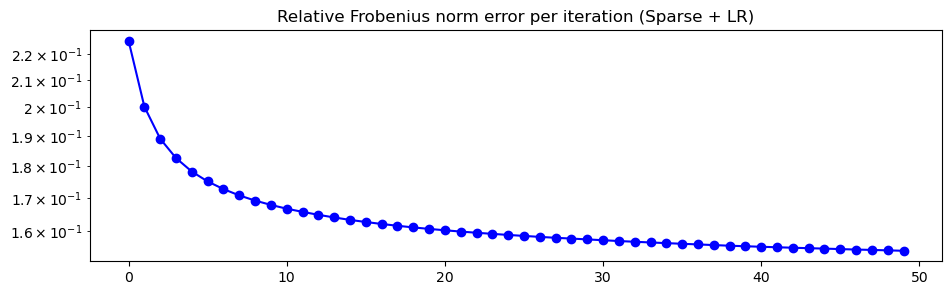

In [327]:
plt.figure(figsize=(11, 3))
plt.title("Relative Frobenius norm error per iteration (Sparse + LR)")
plt.plot(errors, marker='o', linestyle='-', color='b')
plt.yscale('log')

In [281]:
# _, _, debugging_data = weight_decomposition_admm(
#     X=X_mis.T,
#     rank=rank,
#     sparsity=sparsity,
#     rho_admm=0.9,
#     BQ=BQ,
#     BLR=BLR,
#     quantizer_factory=NFQuantizerFactory(method="normal"),
#     iters=100,
#     log_errors=True
# )

In [282]:
# errors, errors_Qp, lagrangians, constraint_vals = debugging_data

In [111]:
print(f"Minimum error: {min(*errors)}")

Minimum error: 0.19378419237484645


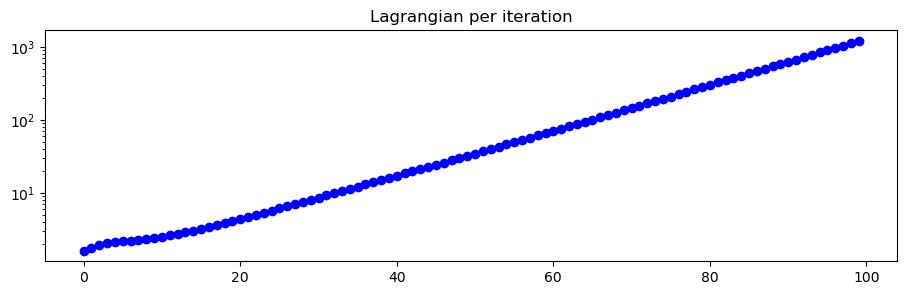

In [112]:
plt.figure(figsize=(11, 3))
plt.title("Lagrangian per iteration")
plt.plot(lagrangians, marker='o', linestyle='-', color='b')
plt.yscale('log')

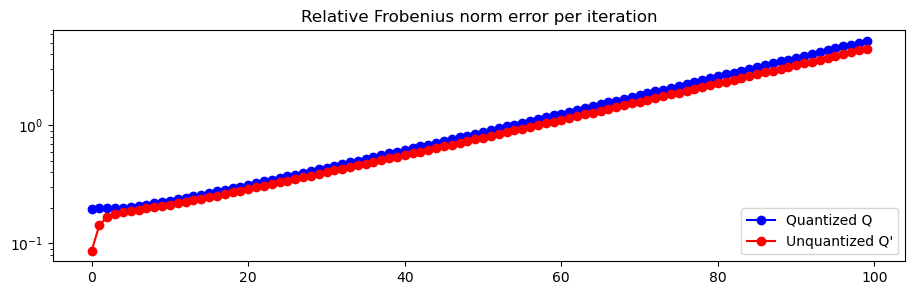

In [113]:
plt.figure(figsize=(11, 3))
plt.title("Relative Frobenius norm error per iteration")
plt.plot(errors, marker='o', linestyle='-', color='b', label="Quantized Q")
plt.plot(errors_Qp, marker='o', linestyle='-', color='r', label="Unquantized Q'")
plt.legend(loc="lower right")
plt.yscale('log')

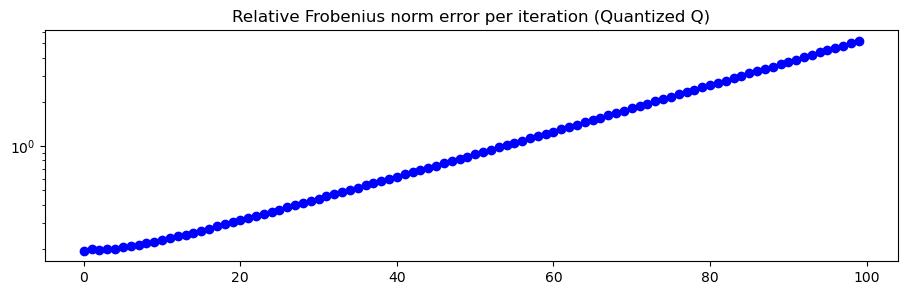

In [114]:
plt.figure(figsize=(11, 3))
plt.title("Relative Frobenius norm error per iteration (Quantized Q)")
plt.plot(errors, marker='o', linestyle='-', color='b', label="Quantized Q")
plt.yscale('log')

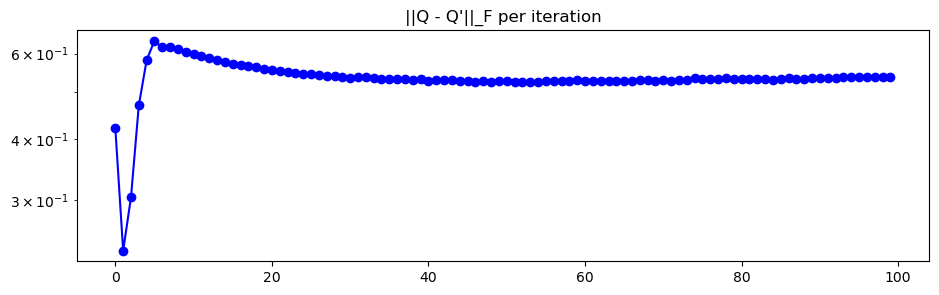

In [113]:
plt.figure(figsize=(11, 3))
plt.title("||Q - Q'||_F per iteration")
plt.plot(constraint_vals, marker='o', linestyle='-', color='b')
plt.yscale('log')

In [14]:
def test_iterative_weight_compression(
    X = None,
    weight_comp_configs: list[WeightCompressionConfig]=[
        WeightCompressionConfig(
            algorithm_type=AlgorithmType.ALTERNATING_MIXED_LPLR,
            algorithm_kwargs={
                "k": 64, "r1": 0, "r2": 0,
                "B1": 8, "B2": 8
            }
        )
    ],
    plot_title = "Frobenius Norm Errors over Iterations",
    seed=42
):
    plot_colors = ["b", "r", "g", "c", "m", "k"]
    plot_markers = ["o", "X", "*"]
    # Set random seed for reproducibility
    torch.manual_seed(seed)

    plt.figure(figsize=(11, 3))
    for i, config in enumerate(weight_comp_configs):
        kwargs = config.algorithm_kwargs.copy()
        algorithm_type = config.algorithm_type
        kwargs["log_errors"] = True

        if config.hadamard:
            result = hadamard_weight_compression(
                X=X, config=WeightCompressionConfig(
                    algorithm_type=config.algorithm_type,
                    algorithm_kwargs=kwargs
                )
            )
            errors = result[-1]
        elif algorithm_type == AlgorithmType.ALTERNATING_MIXED_LPLR:
            kwargs["X"] = X
            _, _, errors = alternating_mixed_lplr(**kwargs)
        elif algorithm_type == AlgorithmType.DIRECT_SVD_LPLR:
            kwargs["X"] = X
            _, _, errors = direct_svd_mixed_lplr(**kwargs)
        elif algorithm_type == AlgorithmType.LOFTQ:
            kwargs["weight"] = X
            _, _, _, errors = loftq_init(**kwargs)
        else: ## Loftq-LPLR
            kwargs["weight"] = X
            _, _, _, errors = loftq_lplr_init(**kwargs)

        fro_norm_X = torch.norm(X, p="fro").item()
        relative_errors = np.array(errors) / fro_norm_X

        # print(relative_errors)
        print(f"Minimum error: {min(*relative_errors)}")

        # Plot errors over iterations
        plt.plot(
            range(1, len(relative_errors) + 1),
            relative_errors,
            marker=plot_markers[(i // len(plot_colors)) % len(plot_markers)],
            linestyle="-",
            markersize=4,
            color=plot_colors[i % len(plot_colors)],
            label=f"Param Set {i+1}*")

    print("-"*80, "\n* Legend Key")
    for i, config in enumerate(weight_comp_configs):
        print(f"Param Set {i+1}: ", config.algorithm_kwargs)
        print("\tusing algorithm type ", config.algorithm_type)
        if config.hadamard:
            print("\twith randomized Hadamard transform")

    plt.title(plot_title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.show()

Minimum error: 0.08971723277004644


KeyboardInterrupt: 

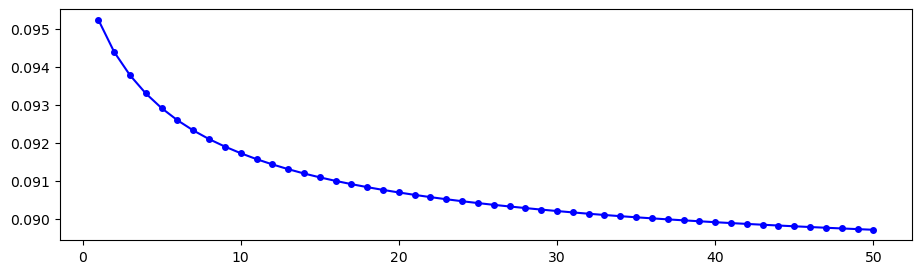

In [329]:
## WITHOUT HADAMARD SKETCH
test_iterative_weight_compression(
    weight_comp_configs=[
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "reduced_rank": 16, "num_iter": 50, "quantizer_factory": QuantizerFactory("normal")
            },
            algorithm_type=AlgorithmType.LOFTQ,
            hadamard=False
        ),
        WeightCompressionConfig(
            algorithm_kwargs={
                "num_bits": 4, "num_bits_factors": 8, "reduced_rank": 16,
                "num_iter": 50, "num_iter_lplr": 30, "quantizer_factory": QuantizerFactory("normal")
            },
            algorithm_type=AlgorithmType.LOFTQ_LPLR,
            hadamard=False
        )
    ],
    plot_title="Frobenius Norm Errors over Iterations",
    X=X_mis.T
)